# Evaluation of the transcripts: Metrics & time passed to verify

- The first part of this notebook is designed to assess the performance of predictions after manual verification. *(Also providing enhanced visual HTML files to help interpret metrics clearly.)*

    - After manually verifying transcripts, you can use the verified transcripts as reference (ground truth) data to test the accuracy of various models.
    
    - **However**, it's essential to note that if the reference file (ground truth) was created by using a model’s predictions as a template the ground truth may carry a bias towards that initial model. *For instance, if a model omitted interruptions or adjusted sentence structure and the verifier found these changes accurate in context, these modifications might remain, unintentionally favoring that model.*

- The second part of the notebook focuses on tracking the time spent verifying each transcript. This data allows you to quantify time savings, providing insights into the efficiency of each model based on verification time.

In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
import pandas as pd
import numpy as np
import shutil
import os

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set()

from utils.evaluation_helpers import process_folder_csv, load_data_time, compute_der, process_folder_text
from utils.format_helpers import get_files

# Predictions vs References: Performance evaluation (ASR & Diarization)

## CSV Files

### Preparing evaluation folder (Predictions vs References)

Usefull if want to test/compare differents models.

In [61]:
directories = ['../results/Compassion', '../results/OBE1', '../results/OBE2'] # The csv file that you want to compare
pred_folder = '../evaluation/predictions' # Specify the name if trying to compare different ASR/Diarization models.

def copy_csv_files(directories, pred_folder):
    pred_files = []
    for directory in directories:
        pred_files.append(get_files(directory, 'csv'))
    pred_files = [item for sublist in pred_files for item in sublist]

    os.makedirs(pred_folder, exist_ok=True)
    for file in pred_files:
        shutil.copy(file, pred_folder)

copy_csv_files(directories, pred_folder)

### ASR and Diarization metrics + Visual Tool to easily understand missmatch

In [62]:
prediction_folder = "../evaluation/predictions"
reference_folder = "../evaluation/references"

# Provide the original duration of the audio files.
# This ensures the diarization error rate (DER) metric accounts for the total audio duration, not just the speech segments detected by the model.
# If this information is missing, DER calculations may be inaccurate as they consider only the detected speech intervals, worsening the DER metric.
orignal_info = pd.read_csv("./outputs/audio_data.csv")

metric = process_folder_csv(prediction_folder, reference_folder, info=orignal_info)
metric.to_csv('../evaluation/metrics.csv', index=False)

Processing file: ID 05.csv
Combined HTML file saved as ../evaluation/predictions\visual_comparison\ID 05_Diarization.html
Processed file: ID 05.csv
Processing file: Id 08.csv
Combined HTML file saved as ../evaluation/predictions\visual_comparison\Id 08_Diarization.html
Processed file: Id 08.csv
Processing file: Id 13.csv
Combined HTML file saved as ../evaluation/predictions\visual_comparison\Id 13_Diarization.html
Processed file: Id 13.csv
Processing file: Id 13b.csv
Combined HTML file saved as ../evaluation/predictions\visual_comparison\Id 13b_Diarization.html
Processed file: Id 13b.csv
Processing file: Id 14.csv
Combined HTML file saved as ../evaluation/predictions\visual_comparison\Id 14_Diarization.html
Processed file: Id 14.csv
Processing file: Id 15.csv
Combined HTML file saved as ../evaluation/predictions\visual_comparison\Id 15_Diarization.html
Processed file: Id 15.csv
Processing file: Id 16.csv
Combined HTML file saved as ../evaluation/predictions\visual_comparison\Id 16_Diar

### (Optional) Dialogue DER Analysis in CSV instead than in HTML

In [63]:
def dialogue_DER(reference_file, prediction_file, output_file=None):
    df_ref, df_pred = load_data_time(reference_file, prediction_file)
    dialogue_df, error_durations = compute_der(df_ref, df_pred)

    # Display error durations and DER
    print("\nError Durations and DER:")
    for key, value in error_durations.items():
        if key == 'DER':
            print(f"{key}: {value:.2%}")
        else:
            print(f"{key}: {value:.3f} seconds")

    if output_file:
        dialogue_df.to_csv(output_file, index=False)

In [64]:
reference_file = "../evaluation/references/S301final.csv"
prediction_file = "../evaluation/predictions/S301final.csv"
output_file = '../outputs/dia_S301final_new.csv'

dialogue_DER(reference_file, prediction_file)#, output_file)


Error Durations and DER:
DER: 6.79%
Reference Speech Duration: 342.280 seconds
Missed Duration: 0.000 seconds
False Alarm Duration: 0.000 seconds
Confusion Duration: 23.240 seconds


# Text File 
When corrections are made directly in a text file rather than adjusting timestamps in a CSV (as was done for the Grief dataset interviews), a simplified approach to DER is required:

Since time segments are not adjusted, we ignore missed speech and false alarm errors. Instead, we focus solely on confusion errors, defined as the number of words reassigned from one speaker to another. *This replaces the traditional time-based DER calculations with a straightforward, text-based method.*

**Note:** This approach can be preferred as it accelerates the manual correction process by providing a better visual representation, with segments concatenated by turn in the text file and by neglecting the need to correct timestamps, it offers significant time savings without compromising the core analysis.

In [65]:
prediction_folder = "../evaluation/grief_text"
reference_folder = "../Dataset/grief_transcripts/text_corrected"

metric = process_folder_text(prediction_folder, reference_folder,dir_visual="grief_visual_text")
metric.to_csv('../evaluation/grief_metrics_text.csv', index=False)

Processing text file: ADE_pilot_003_merged.txt
Misassigned words: 264
Total words reference: 11614
Processed file: ADE_pilot_003_merged.txt
Processing text file: ADE_pilot_004_merged.txt
Misassigned words: 144
Total words reference: 9830
Processed file: ADE_pilot_004_merged.txt
Processing text file: ADE_pilot_005_merged.txt
Misassigned words: 246
Total words reference: 6051
Processed file: ADE_pilot_005_merged.txt
Processing text file: ADE_pilot_006_merged.txt
Misassigned words: 244
Total words reference: 7461
Processed file: ADE_pilot_006_merged.txt
Processing text file: ADE_pilot_007_merged.txt
Misassigned words: 128
Total words reference: 9491
Processed file: ADE_pilot_007_merged.txt
Processing text file: ADE_pilot_008_merged.txt
Misassigned words: 277
Total words reference: 14198
Processed file: ADE_pilot_008_merged.txt
Processing text file: ADE_pilot_009_merged.txt
Misassigned words: 187
Total words reference: 10642
Processed file: ADE_pilot_009_merged.txt
Processing text file: AD

In [66]:
prediction_folder = "../evaluation/predictions_text"
reference_folder = "../evaluation/references_text"

metric = process_folder_text(prediction_folder, reference_folder,dir_visual="med_visual_text")
metric.to_csv('../evaluation/med_metrics_text.csv', index=False)

Processing text file: ID 05.txt
Misassigned words: 130
Total words reference: 1106
Processed file: ID 05.txt
Processing text file: Id 08.txt
Misassigned words: 87
Total words reference: 698
Processed file: Id 08.txt
Processing text file: Id 13.txt
Misassigned words: 121
Total words reference: 1480
Processed file: Id 13.txt
Processing text file: Id 13b.txt
Misassigned words: 11
Total words reference: 576
Processed file: Id 13b.txt
Processing text file: Id 14.txt
Misassigned words: 20
Total words reference: 511
Processed file: Id 14.txt
Processing text file: Id 15.txt
Misassigned words: 0
Total words reference: 325
Processed file: Id 15.txt
Processing text file: Id 16.txt
Misassigned words: 59
Total words reference: 436
Processed file: Id 16.txt
Processing text file: Id 17.txt
Misassigned words: 6
Total words reference: 472
Processed file: Id 17.txt
Processing text file: Id 18.txt
Misassigned words: 42
Total words reference: 491
Processed file: Id 18.txt
Processing text file: Id 19.txt
M

# Visualize performance metrics

## Meditations Visualisation

In [67]:
# Create a mapping of Filename to Experiment
df_audio = pd.read_csv('./outputs/audio_data.csv')
filename_to_experiment = dict(zip(df_audio['File Name'],df_audio['Experiment']))

df = pd.read_csv('../evaluation/metrics.csv')
df['Experiment'] = df['Filename'].map(filename_to_experiment)
df

,Filename,WER,DER,Total Words,Deletions,Insertions,Substitutions,Reference Speech Duration,Missed Duration,False Alarm Duration,Confusion Duration,Experiment
0,ID 05,0.0271,0.1156,1106,1,25,4,615.68,4.0,0.0,67.200,OBE1
1,Id 08,0.0187,0.0564,695,1,8,4,274.65,0.0,0.0,15.500,OBE1
2,Id 13,0.0230,0.0657,1479,6,27,1,439.70,0.0,0.0,28.880,OBE1
3,Id 13b,0.0017,0.0541,576,0,0,1,201.60,0.0,0.0,10.900,OBE1
4,Id 14,0.0317,0.0568,505,1,9,6,172.97,0.0,0.0,9.820,OBE1
...,...,...,...,...,...,...,...,...,...,...,...,...
77,S304,0.0266,0.1214,1203,5,21,6,425.92,0.0,0.0,51.699,Compassion
78,S305con,0.1518,0.0148,191,0,29,0,101.10,1.0,0.0,0.500,Compassion
79,S306,0.0097,0.0780,1450,1,3,10,530.71,0.0,0.0,41.400,Compassion
80,S307,0.0272,0.1578,734,3,4,13,375.70,0.0,0.0,59.300,Compassion


In [68]:
def plot_histograms(df):
    """
    Plots histograms for WER and DER distributions.
    
    Args:
        df (pd.DataFrame): DataFrame containing the metrics.
    """
    plt.figure(figsize=(12, 6))

    # Define bins dynamically based on the maximum values in the data
    wer_max = df['WER'].max()
    der_max = df['DER'].max()
    
    wer_bins = np.arange(0, wer_max + 0.05, 0.05)  # Bins for WER
    der_bins = np.arange(0, der_max + 0.05, 0.05)  # Bins for DER
    
    # Histogram for WER
    plt.subplot(1, 2, 1)
    ax1 = sns.histplot(df['WER'], bins=wer_bins, kde=True, color='skyblue')
    plt.xlabel('Word Error Rate (WER)')
    #plt.title('Distribution of WER')
    plt.xticks(np.arange(0, wer_max + 0.1, 0.1))  # X-ticks at 10% intervals

    # Annotate each bar with percentage
    for p in ax1.patches:
        height = p.get_height()
        if height > 0:
            percentage = (height / df['WER'].shape[0]) * 100
            ax1.annotate(f'{percentage:.1f}%', 
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='bottom', fontsize=10, color='black')
    
    # Histogram for DER
    plt.subplot(1, 2, 2)
    ax2 = sns.histplot(df['DER'], bins=der_bins, kde=True, color='salmon')
    plt.xlabel('Diarization Error Rate (DER)')
    #plt.title('Distribution of DER')
    plt.xticks(np.arange(0, der_max + 0.1, 0.1))  # X-ticks at 10% intervals

    # Annotate each bar with percentage
    for p in ax2.patches:
        height = p.get_height()
        if height > 0:
            percentage = (height / df['DER'].shape[0]) * 100
            ax2.annotate(f'{percentage:.1f}%', 
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='bottom', fontsize=10, color='black')
    
    plt.tight_layout()
    plt.show()

def plot_boxplots(df, title=None, file_name=None):
    """
    Plots box plots for WER and DER.
    
    Args:
        df (pd.DataFrame): DataFrame containing the metrics.
    """
    plt.figure(figsize=(8, 4))
    
    # Melt the DataFrame for easier plotting with Seaborn
    melted_df = df.melt(id_vars='Filename', value_vars=['WER', 'DER'], var_name='Metric', value_name='Value')
    ax = sns.boxplot(x='Metric', y='Value',hue="Metric" ,data=melted_df, palette=['skyblue', 'salmon'])
    plt.ylabel('Error Rate')
    plt.xlabel('')
    if title:
        plt.title(title)
    
    # Calculate and print medians
    medians = melted_df.groupby('Metric')['Value'].median()
    print("Median Values:")
    for metric, median_value in medians.items():
        print(f"  {metric}: {median_value:.3f}")
    
    plt.tight_layout()
    if file_name:
        plt.savefig(file_name, dpi=600)
    plt.show()

def plot_wer_vs_der_scatter(df):
    """
    Plots an interactive scatter plot of WER vs. DER using Plotly.
    
    Args:
        df (pd.DataFrame): DataFrame containing the metrics, must include 'WER', 'DER', and 'Filename' columns.
    """
    fig = px.scatter(
        df,
        x='WER',
        y='DER',
        color='Filename',
        hover_data=['Filename','Experiment'],  # Show filenames on hover
        labels={
            'WER': 'Word Error Rate (WER)',
            'DER': 'Diarization Error Rate (DER)'
        },
        title='Interactive Scatter Plot of WER vs. DER'
    )
    fig.update_traces(marker=dict(size=10))
    fig.update_layout(
        xaxis_title='Word Error Rate (WER)',
        yaxis_title='Diarization Error Rate (DER)',
        showlegend=False
    )
    fig.show()

Median Values:
  DER: 0.106
  WER: 0.024


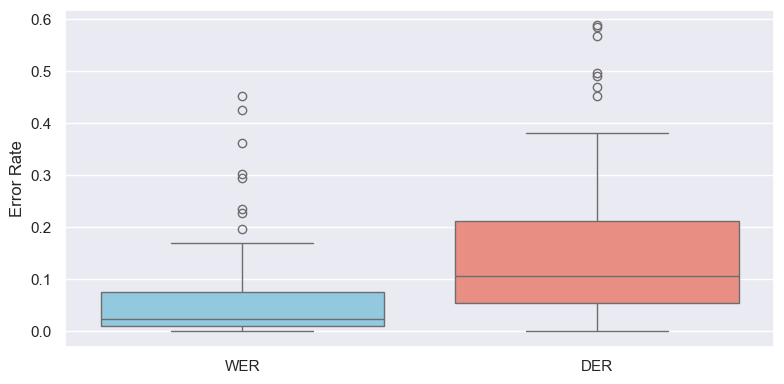

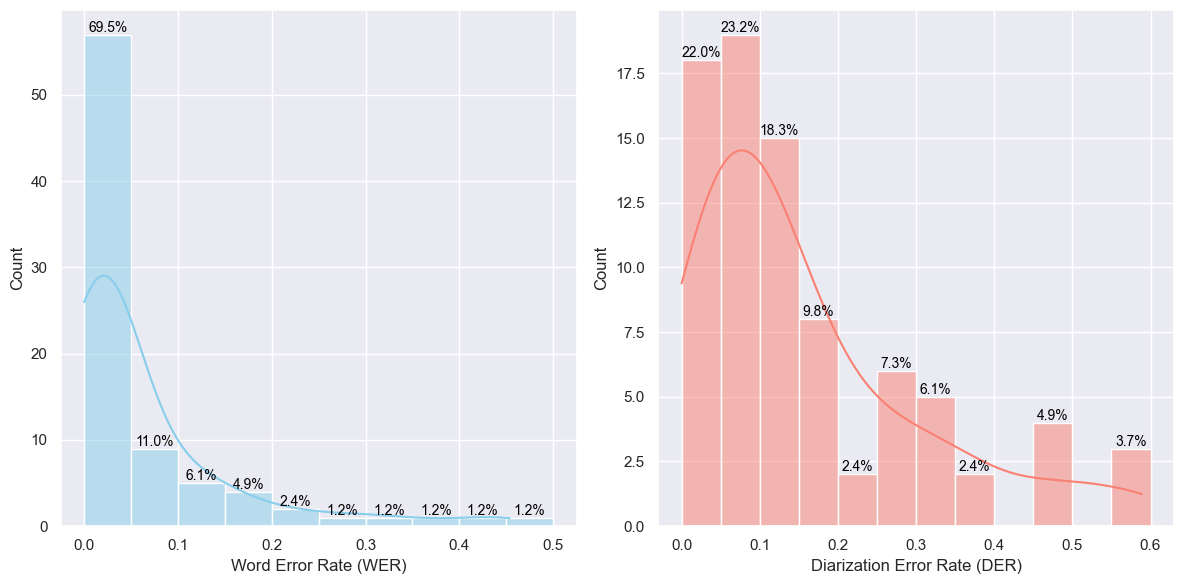

In [69]:
plot_boxplots(df)
plot_histograms(df)
plot_wer_vs_der_scatter(df)

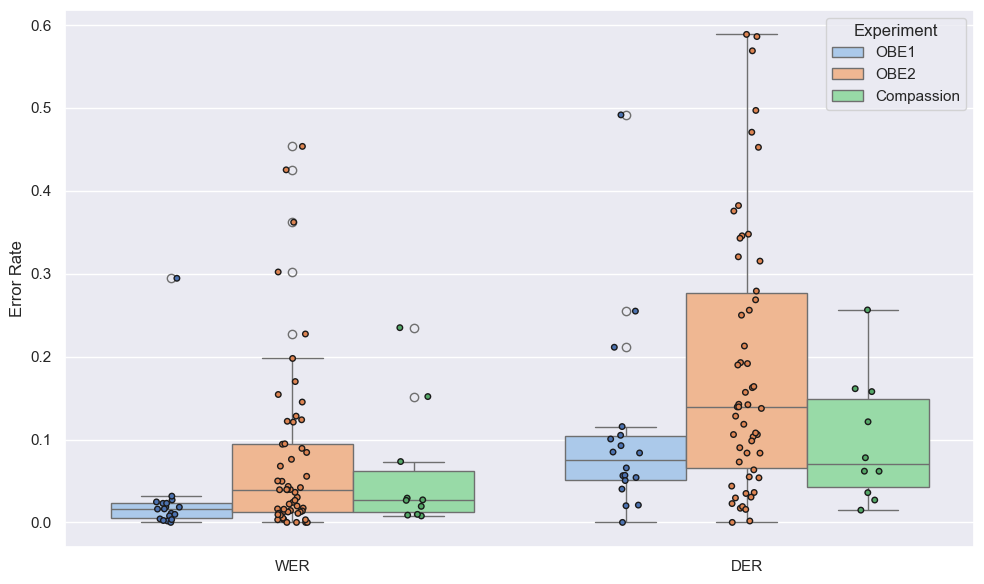

In [70]:
def plot_boxplot_experiment(df):
    """
    Plots box plots for WER and DER, grouped by Experiment.
    
    Args:
        df (pd.DataFrame): DataFrame containing the metrics and Experiment column.
    """
    plt.figure(figsize=(10, 6))
    
    # Melt the DataFrame for easier plotting with Seaborn
    melted_df = df.melt(id_vars=['Filename', 'Experiment'], 
                        value_vars=['WER', 'DER'], 
                        var_name='Metric', 
                        value_name='Value')
    
    # Create the boxplot with Experiment as hue
    sns.boxplot(x='Metric', y='Value', hue='Experiment', data=melted_df, palette='pastel')
    sns.stripplot(x='Metric', y='Value', hue='Experiment', data=melted_df, size=4, linewidth=1,dodge=True, jitter=True, legend=False, edgecolor="k")
    
    plt.ylabel('Error Rate')
    plt.xlabel('')
    #plt.title('Boxplots of WER and DER by Experiment')
    plt.legend(title='Experiment')
    plt.tight_layout()
    plt.show()

plot_boxplot_experiment(df)

## Grief & Meditation Comparaison

In [71]:
df_g = pd.read_csv('../evaluation/grief_metrics_text.csv')
df_m = pd.read_csv('../evaluation/med_metrics_text.csv')

In [72]:
df_g["Group"] = "Grief"
df_m["Group"] = "Meditation"

# Concatenate the two DataFrames
df_text = pd.concat([df_m, df_g], ignore_index=True)
df_text

,Filename,WER,DER,Total Words,Deletions,Insertions,Substitutions,Words Confusions,Group
0,ID 05,0.0271,0.117541,1106,1,25,4,130,Meditation
1,Id 08,0.0229,0.124642,698,1,11,4,87,Meditation
2,Id 13,0.0236,0.081757,1480,6,27,2,121,Meditation
3,Id 13b,0.0017,0.019097,576,0,0,1,11,Meditation
4,Id 14,0.0372,0.039139,511,0,15,4,20,Meditation
...,...,...,...,...,...,...,...,...,...
85,ADE_pilot_006_merged,0.0251,0.032703,7461,61,72,54,244,Grief
86,ADE_pilot_007_merged,0.0081,0.013486,9491,22,23,32,128,Grief
87,ADE_pilot_008_merged,0.0083,0.019510,14198,39,51,28,277,Grief
88,ADE_pilot_009_merged,0.0159,0.017572,10642,78,54,37,187,Grief


Median Values:
  DER: 0.019
  WER: 0.020


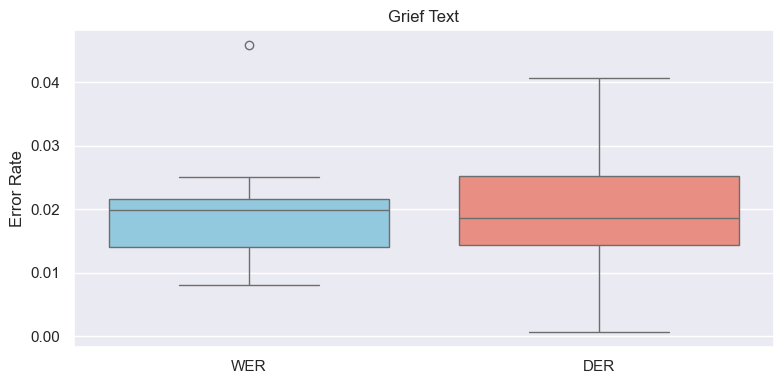

In [73]:
plot_boxplots(df_g,title="Grief Text", file_name="../outputs/grief_text_boxplot.png")

Median Values:
  DER: 0.139
  WER: 0.027


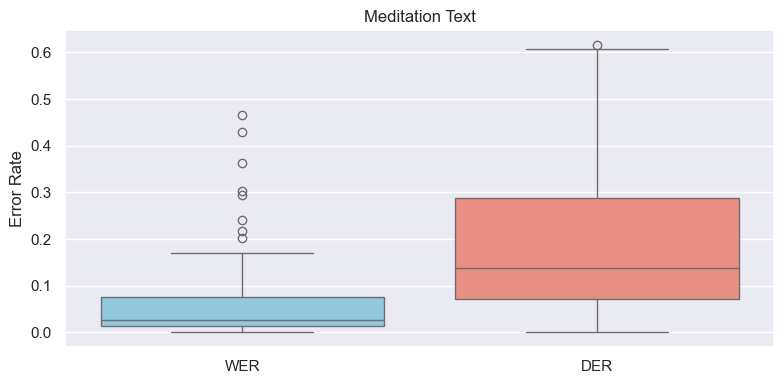

In [74]:
plot_boxplots(df_m,title="Meditation Text", file_name="outputs/med_text_boxplot.png")

In [89]:
def plot_boxplots_group(df, title=None, file_name=None):
    """
    Plots boxplots for WER and DER, grouped by the 'Group' column.
    
    Args:
        df (pd.DataFrame): DataFrame containing the metrics.
    """
    plt.figure(figsize=(10, 6))
    
    # Melt the DataFrame for easier plotting with Seaborn
    melted_df = df.melt(
        id_vars=['Filename', 'Group'], 
        value_vars=['WER', 'DER'], 
        var_name='Metric', 
        value_name='Value'
    )

    # Calculate medians grouped by Metric and Group
    medians = melted_df.groupby(['Metric', 'Group'])['Value'].median()
    print("Median Values:")
    print("-" * 50)
    print(medians.to_string())
    
    # Create the boxplot
    sns.boxplot(x='Metric', y='Value', hue='Group', data=melted_df, palette='Set2')
    
    # Add labels and title
    plt.ylabel('Error Rate')
    plt.xlabel('Metric')
    if title:
        plt.title(title)
    plt.legend(title='Group')

    # Layout adjustments
    plt.tight_layout()
    if file_name:
        plt.savefig(file_name, dpi=600)
    plt.show()

def plot_boxplots_group_separated(df, tittle=None, file_name=None):
    """
    Plots two boxplots in subplots for WER and DER, grouped by the 'Group' column.
    
    Args:
        df (pd.DataFrame): DataFrame containing the metrics.
    """
    # Melt the DataFrame for easier plotting with Seaborn
    melted_df = df.melt(
        id_vars=['Filename', 'Group'], 
        value_vars=['WER', 'DER'], 
        var_name='Metric', 
        value_name='Value',
    )
    
    # Calculate medians grouped by Metric and Group
    medians = melted_df.groupby(['Metric', 'Group'])['Value'].median()
    print("Median Values:")
    print("-" * 50)
    print(medians.to_string())

    
    # Create the subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
    
    # Plot WER boxplot
    sns.boxplot(
        ax=axes[0],
        x='Group', y='Value', 
        data=melted_df[melted_df['Metric'] == 'WER'], 
        palette='Set2',
        hue='Group'
    )
    axes[0].set_title('WER by Group')
    axes[0].set_ylabel('WER')
    axes[0].set_xlabel('Group')
    
    # Plot DER boxplot
    sns.boxplot(
        ax=axes[1],
        x='Group', y='Value', 
        data=melted_df[melted_df['Metric'] == 'DER'], 
        palette='Set2',
        hue='Group'
    )
    axes[1].set_title('DER by Group')
    axes[1].set_ylabel('DER')
    axes[1].set_xlabel('Group')

    if tittle:
        fig.suptitle(tittle, fontsize=16)
    
    # Adjust layout
    plt.tight_layout()
    if file_name:
        plt.savefig(file_name, dpi=600)
    plt.show()

Median Values:
--------------------------------------------------
Metric  Group     
DER     Grief         0.018541
        Meditation    0.139089
WER     Grief         0.019950
        Meditation    0.026550


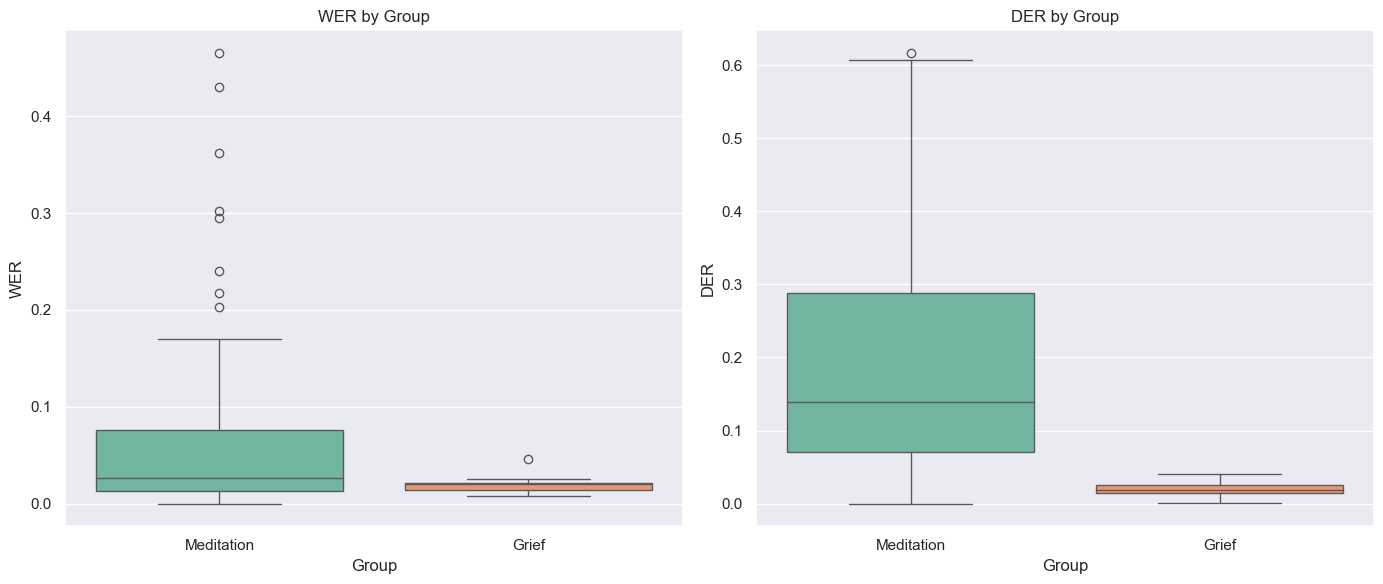

In [90]:
plot_boxplots_group_separated(df_text, file_name="outputs/comparaison_boxplot_2sub.png")

Median Values:
--------------------------------------------------
Metric  Group     
DER     Grief         0.018541
        Meditation    0.139089
WER     Grief         0.019950
        Meditation    0.026550


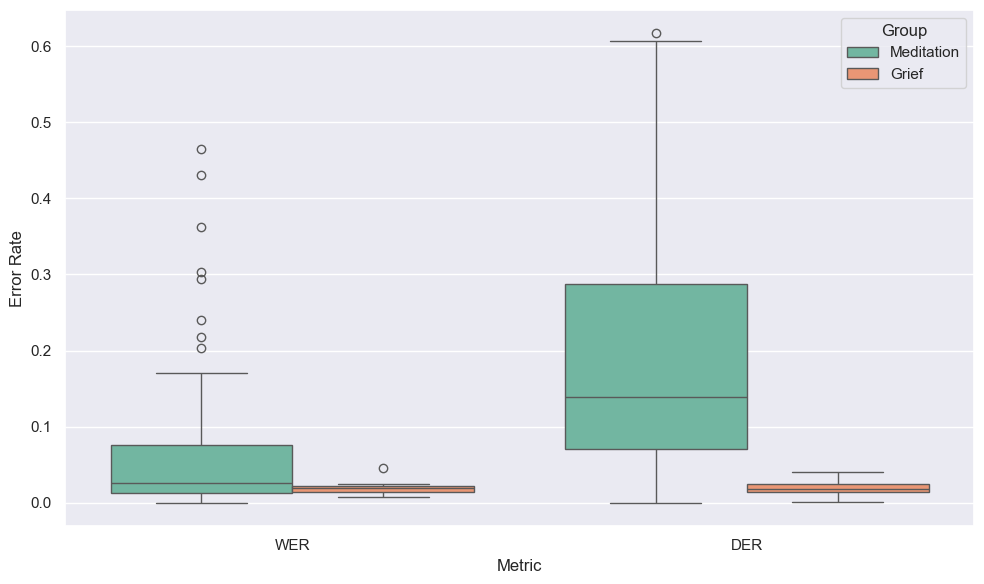

In [91]:
plot_boxplots_group(df_text, file_name="outputs/comparaison_boxplot_1.png")

# Estimation of time passed verify transcription

In [79]:
df_time = pd.read_csv("outputs/time_data.csv")

# Function to convert HH:MM:SS to total seconds
def time_to_seconds(time_str):
    try:
        h, m, s = map(int, time_str.split(':'))
        return h * 3600 + m * 60 + s
    except:
        return np.nan  # Return NaN if time_str is not a valid format

df_time['Verification_sec'] = df_time['Verification_time'].apply(time_to_seconds)

# Drop rows where 'Verification_sec' is NaN
df_time = df_time.dropna(subset=['Verification_sec'])

df_time.loc[:, 'Ratio'] = df_time['Verification_sec'] / df_time['Duration_sec'] 

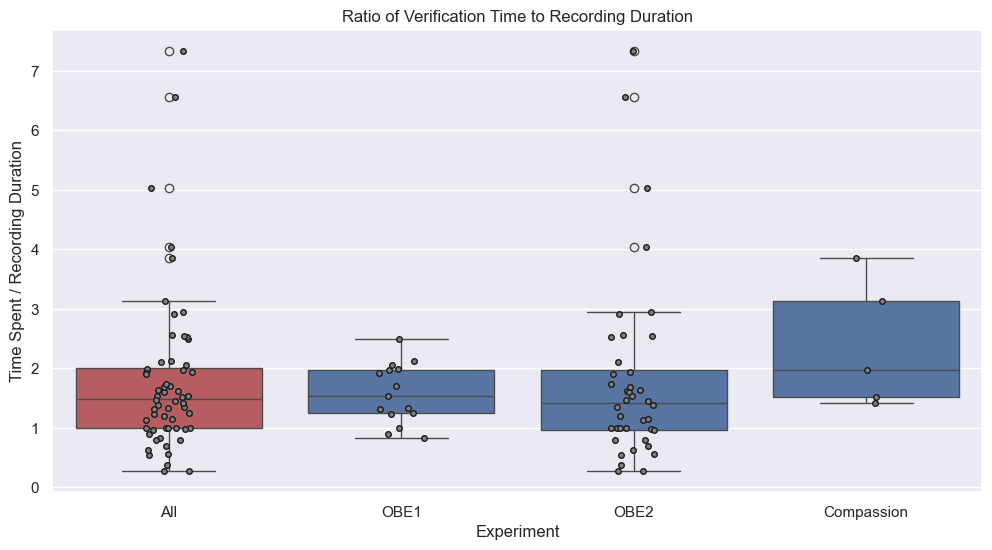

In [80]:
# Add a new row for the "All" category
df_all = df_time.copy()
df_all['Experiment'] = 'All'

# Concatenate the original data with the "All" data
df_combined = pd.concat([df_all, df_time])
default_palette = sns.color_palette("deep")  
palette = {experiment: (default_palette[0] if experiment != 'All' else default_palette[3]) for experiment in df_combined['Experiment'].unique()}

# Plot the box plot with "All" as an additional category
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_combined, x='Experiment', y='Ratio', palette=palette, hue='Experiment')
sns.stripplot(data=df_combined, x='Experiment', y='Ratio', size=4, linewidth=1, dodge=True, jitter=True, edgecolor='k', color='gray')
plt.title('Ratio of Verification Time to Recording Duration')
plt.xlabel('Experiment')
plt.ylabel('Time Spent / Recording Duration')
plt.show()

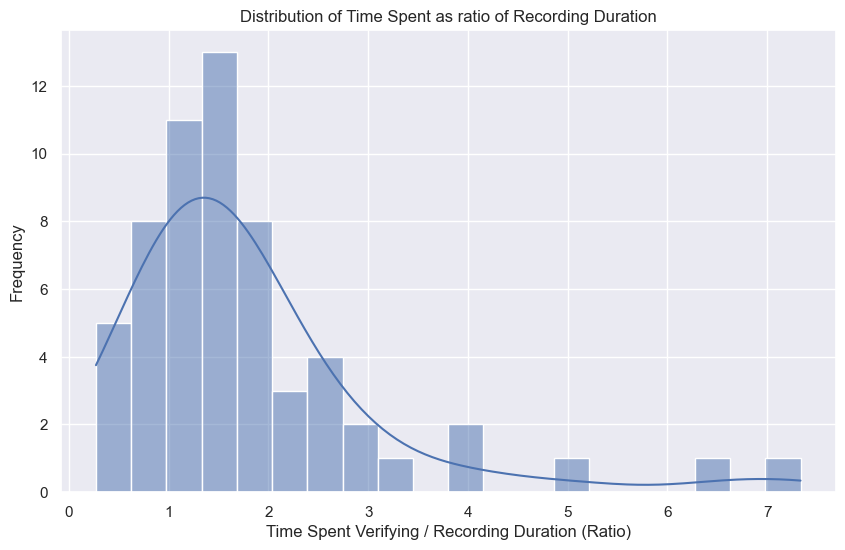

In [81]:
plt.figure(figsize=(10, 6))
sns.histplot(df_time['Ratio'].dropna(), kde=True, bins=20)
plt.title('Distribution of Time Spent as ratio of Recording Duration')
plt.xlabel('Time Spent Verifying / Recording Duration (Ratio)')
plt.ylabel('Frequency')
plt.show()